<a href="https://colab.research.google.com/github/ShivamSinghal1/FacialEmotionRecognition/blob/master/CK%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [11]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential , load_model
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.initializers import  RandomNormal
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, TensorBoard ,EarlyStopping, ReduceLROnPlateau
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


#Import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data_dir = "/content/drive/My Drive/Dataset/CK+48"
datagen = ImageDataGenerator()
generator = datagen.flow_from_directory(    data_dir,
                                              target_size=(48,48),
                                              color_mode="grayscale",
                                              subset="training",
                                              class_mode='categorical')

Found 981 images belonging to 7 classes.


In [9]:
y = []
X = []
for i in range(0,len(generator)):
    X_i = generator.__getitem__(i)[0]
    Y_i = generator.__getitem__(i)[1]
    for t in Y_i:
      y.append(np.argmax(t))
    for x in X_i:
      X.append(x)

In [25]:
X = np.array(X)
y = np.array(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    shuffle=True, stratify=y,
                                                    test_size=0.2, random_state=2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((784, 48, 48, 1), (197, 48, 48, 1), (784,), (197,))

#CNN Model

In [26]:
# Data Preparation 

from sklearn import preprocessing
X_train /= 255.
X_valid /= 255.

from keras.utils import np_utils
num_classes = 7
print("Shape before one-hot encoding: ", y_train.shape)
y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
print("Shape after one-hot encoding: ", y_train.shape)

print(X_train.shape , y_train.shape)
print(X_valid.shape , y_valid.shape)

Shape before one-hot encoding:  (784,)
Shape after one-hot encoding:  (784, 7)
(784, 48, 48, 1) (784, 7)
(197, 48, 48, 1) (197, 7)


In [27]:
def get_cnn_model():
    model = Sequential()

    model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [28]:
model = get_cnn_model()

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 128)      

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])


# Saving model each time it achieves lower loss on the validation set
filepath='/content/drive/My Drive/Dataset/ck_vgg16_v2.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=8,
                          verbose=1,
                          restore_best_weights=True, mode = 'auto'
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.9,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)


history = model.fit(X_train , y_train, batch_size = 4
                   , epochs=300, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpointer,earlystop,reduce_lr]
                             )

pd.DataFrame(history.history).to_csv("/content/drive/My Drive/Dataset/ck_history.csv")

Epoch 1/300
196/196 [==============================] - ETA: 0s - loss: 2.0450 - accuracy: 0.2500
Epoch 00001: val_loss improved from inf to 1.99959, saving model to /content/drive/My Drive/Dataset/ck_vgg16_v3.hdf5
196/196 [==============================] - 69s 351ms/step - loss: 2.0450 - accuracy: 0.2500 - val_loss: 1.9996 - val_accuracy: 0.2132
Epoch 2/300
196/196 [==============================] - ETA: 0s - loss: 1.8169 - accuracy: 0.3393
Epoch 00002: val_loss improved from 1.99959 to 1.55402, saving model to /content/drive/My Drive/Dataset/ck_vgg16_v3.hdf5
196/196 [==============================] - 69s 350ms/step - loss: 1.8169 - accuracy: 0.3393 - val_loss: 1.5540 - val_accuracy: 0.3959
Epoch 3/300
196/196 [==============================] - ETA: 0s - loss: 1.5483 - accuracy: 0.4490
Epoch 00003: val_loss did not improve from 1.55402
196/196 [==============================] - 68s 345ms/step - loss: 1.5483 - accuracy: 0.4490 - val_loss: 1.7751 - val_accuracy: 0.3706
Epoch 4/300
196/19

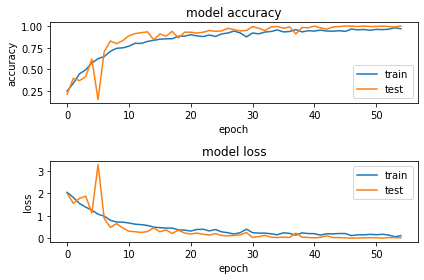

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [42]:
model = load_model('/content/drive/My Drive/Dataset/ck_vgg16_v2.hdf5')
X_test = X_valid
y_test = y_valid

In [43]:
y_predict = model.predict(X_test)

In [37]:
# Plot confusion matrix 

import seaborn as sns
import matplotlib.pyplot as plt

def create_confmat(true_labels, predicted_labels, columns, colour = 'Greens', size = (20,14)):
    sns.set(font_scale=1.5)
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

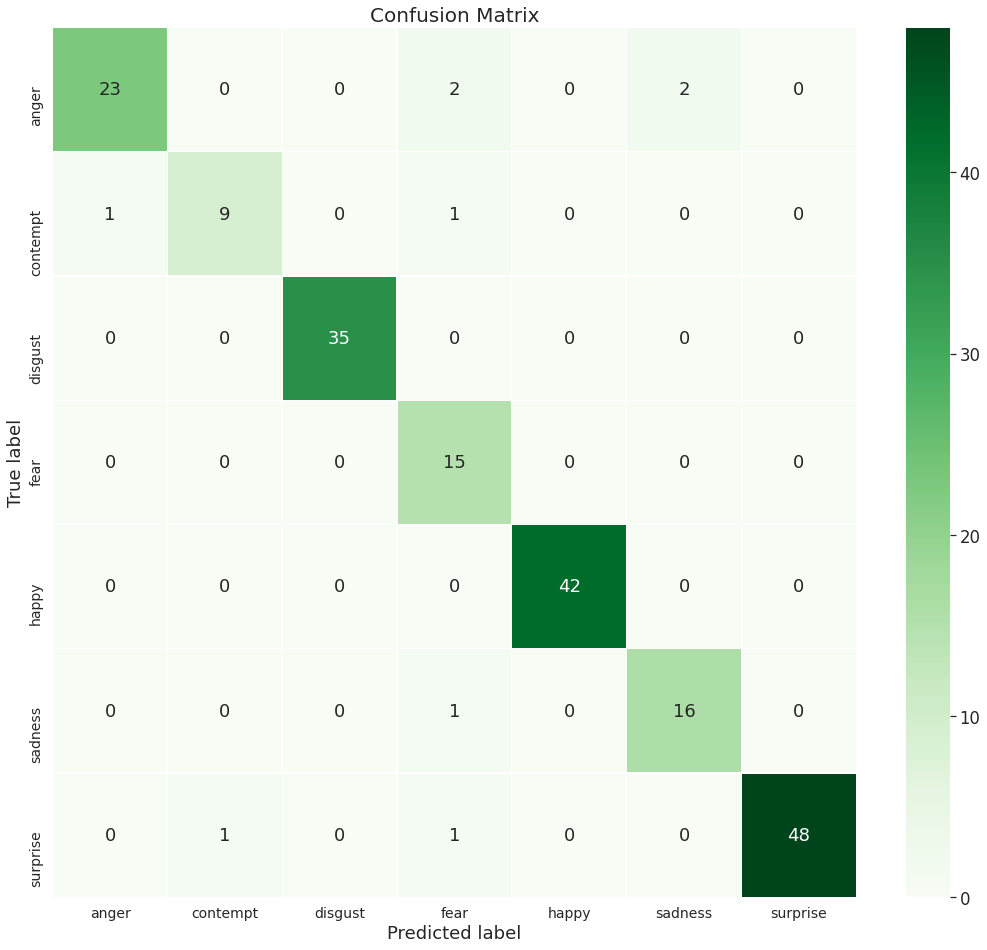

In [46]:
y_p = []
y_t = []
for y in y_predict : 
  y_p.append(np.argmax(y))
for y in y_test : 
  y_t.append(np.argmax(y))
create_confmat(y_t , y_p , ['anger' , 'contempt' , 'disgust' , 'fear' , 'happy' , 'sadness' , 'surprise'])

In [48]:
cnt = 0
for i in range(0 , len(y_t)):
  cnt += y_t[i] == y_p[i]
print(cnt/len(y_t))

0.9543147208121827


In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_t , y_p))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90        27
           1       0.90      0.82      0.86        11
           2       1.00      1.00      1.00        35
           3       0.75      1.00      0.86        15
           4       1.00      1.00      1.00        42
           5       0.89      0.94      0.91        17
           6       1.00      0.96      0.98        50

    accuracy                           0.95       197
   macro avg       0.93      0.94      0.93       197
weighted avg       0.96      0.95      0.96       197



In [44]:
from sklearn.metrics import roc_auc_score

print ( 'AUC Score : ' , roc_auc_score(y_test, y_predict, labels= ['anger' , 'contempt' , 'disgust' , 'fear' , 'happy' , 'sadness' , 'surprise']) )

AUC Score :  0.9948602094026715


#SVM

####Data Prepration

In [ ]:
X_train = X_train.reshape(X_train.shape[0] , 48*48)
X_test = X_valid.reshape(X_valid.shape[0] , 48*48)
y_test = y_valid

####Preprocessing for SVM

In [ ]:
#Standardisation of data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))


In [ ]:
#Applying PCA to retain 95% variation and reduce features
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
pca.fit(X_train)
X_test_p = pca.transform(X_test)
X_train_p = pca.transform(X_train)
print(X_test_p.shape)
pca.explained_variance_ratio_*100
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p.astype(np.float32))
X_test_p = scaler.transform(X_test_p.astype(np.float32))


(193, 102)


####Using linear kernel SVM

In [ ]:
model = SVC(kernel='linear')
model.fit(X_train_p,y_train)
model.score(X_test_p , y_test)

0.6580310880829016

####Using rbf kernel SVM

In [ ]:
#Using rbf kernel 
from sklearn.svm import SVC
model = SVC(kernel='rbf', probability=True )
model.fit(X_train_p,y_train)
model.score(X_test_p , y_test)

0.6839378238341969

####Parameter Tuning Using GridSearch

In [ ]:
param_grid = {'C': [1 ,10 ,100,1000,10000], 
          
              'gamma': [0.00001,.0001,.001,0.01 , .1 ,1 ], 
              
              'kernel':['linear','rbf'],

              'decision_function_shape':['ovr','ovo','dag']
              
              }

          # , 0.001, 0.005, 0.01, 0.1
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(), param_grid,verbose=10,cv=5)
clf = clf.fit(X_train_p, y_train)
print(classification_report(y_test ,clf.predict(X_test_p)))
clf.best_estimator_


Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear ....
[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear, score=0.804, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear ....
[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear, score=0.753, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear, score=0.797, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear ....
[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear, score=0.771, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear ....
[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=linear, score=0.726, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf .......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, score=0.253, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf .......
[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, score=0.253, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf .......


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s


[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, score=0.253, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf .......
[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, score=0.255, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf .......


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s


[CV]  C=1, decision_function_shape=ovr, gamma=1e-05, kernel=rbf, score=0.255, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear ...
[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear, score=0.804, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear ...
[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear, score=0.753, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear ...
[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear, score=0.797, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear ...
[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear, score=0.771, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear ...
[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear, score=0.726, total=   0.1s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=rbf ......
[C

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  1.7min finished


              precision    recall  f1-score   support

           0       0.55      0.67      0.60        27
           1       0.75      0.30      0.43        10
           2       0.81      0.63      0.71        35
           3       0.50      0.07      0.12        15
           4       0.79      1.00      0.88        41
           5       0.67      0.12      0.21        16
           6       0.65      0.96      0.78        49

    accuracy                           0.69       193
   macro avg       0.67      0.54      0.53       193
weighted avg       0.69      0.69      0.65       193



SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

####Parameter Tuning Using RandomizedSearch

In [ ]:
param_grid = {'C': [i for i in range(1,10000)], #1 ,10 ,100,1000,10000
          
              'gamma': [0.000001,0.00001,.00005,.0001,.0005,.001,.005,0.01, .1 ,1,10],
              
              'kernel':['linear','rbf'],

              'decision_function_shape':['ovr','ovo','dag']
              
              }

          # , 0.001, 0.005, 0.01, 0.1
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(), param_grid,verbose=10,cv=5)

clf=RandomizedSearchCV(SVC(), param_grid, n_iter=3000, cv=5, verbose=10)
clf = clf.fit(X_train_p, y_train)
print(classification_report(y_test ,clf.predict(X_test_p)))
clf.best_estimator_

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
[CV] kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924 ...
[CV]  kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924, score=0.778, total=   0.1s
[CV] kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924 ...
[CV]  kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924, score=0.829, total=   0.1s
[CV] kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924, score=0.816, total=   0.1s
[CV] kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924 ...
[CV]  kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924, score=0.847, total=   0.1s
[CV] kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924 ...
[CV]  kernel=rbf, gamma=0.0001, decision_function_shape=ovo, C=7924, score=0.790, total=   0.1s
[CV] kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


[CV]  kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407, score=0.772, total=   0.1s
[CV] kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407 .
[CV]  kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407, score=0.816, total=   0.1s
[CV] kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407 .
[CV]  kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407, score=0.810, total=   0.1s
[CV] kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407 .


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s


[CV]  kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407, score=0.847, total=   0.1s
[CV] kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407 .
[CV]  kernel=linear, gamma=0.005, decision_function_shape=ovo, C=5407, score=0.783, total=   0.1s
[CV] kernel=linear, gamma=5e-05, decision_function_shape=ovr, C=725 ..
[CV]  kernel=linear, gamma=5e-05, decision_function_shape=ovr, C=725, score=0.772, total=   0.1s
[CV] kernel=linear, gamma=5e-05, decision_function_shape=ovr, C=725 ..


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV]  kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951, score=0.772, total=   0.1s
[CV] kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951 
[CV]  kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951, score=0.816, total=   0.1s
[CV] kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951 
[CV]  kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951, score=0.810, total=   0.1s
[CV] kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951 
[CV]  kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951, score=0.847, total=   0.1s
[CV] kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951 
[CV]  kernel=linear, gamma=0.0005, decision_function_shape=ovo, C=9951, score=0.783, total=   0.1s
[CV] kernel=rbf, gamma=0.01, decision_function_shape=ovo, C=7435 .....
[CV]  kernel=rbf, gamma=0.01, decision_function_shape=ovo, C=7435, score=0.804, total=   0.2s
[CV] 

[Parallel(n_jobs=1)]: Done 15000 out of 15000 | elapsed: 26.2min finished


              precision    recall  f1-score   support

           0       0.53      0.74      0.62        27
           1       0.60      0.30      0.40        10
           2       0.90      0.80      0.85        35
           3       0.50      0.20      0.29        15
           4       0.70      0.95      0.80        41
           5       0.78      0.44      0.56        16
           6       0.85      0.84      0.85        49

    accuracy                           0.73       193
   macro avg       0.69      0.61      0.62       193
weighted avg       0.74      0.73      0.71       193



SVC(C=6701, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

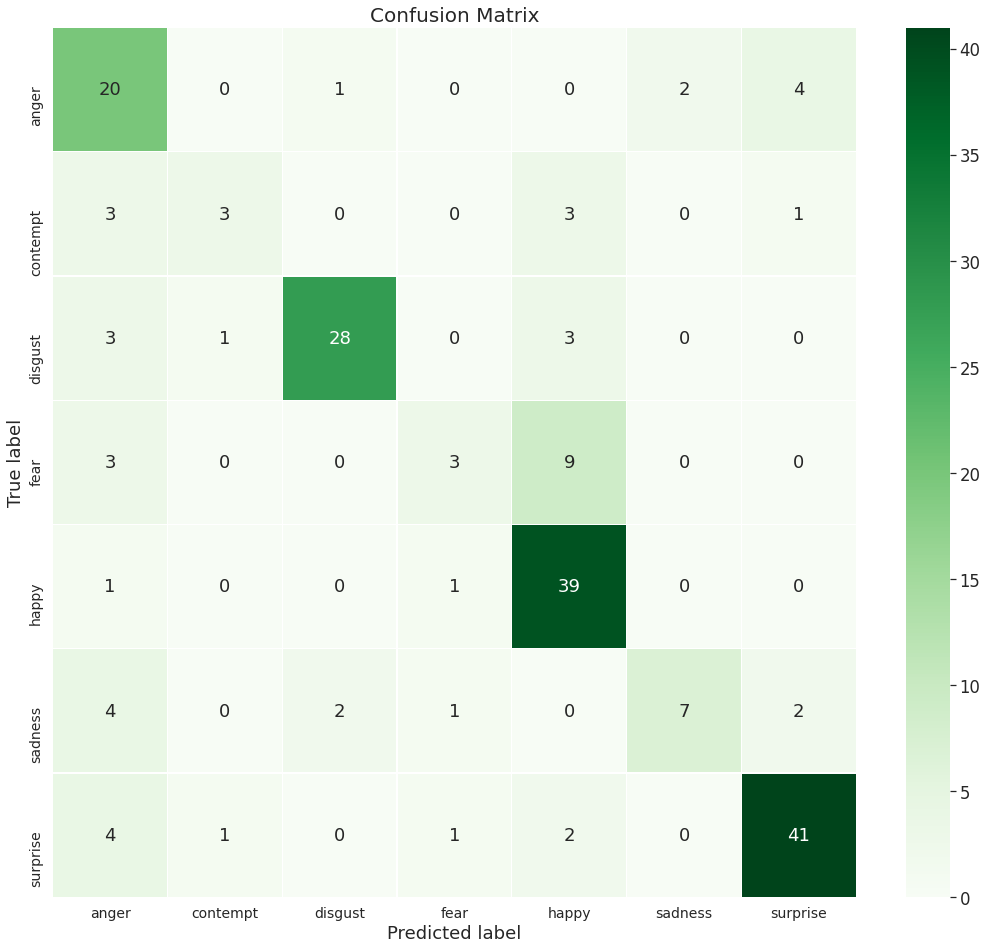

In [ ]:
y_predict = clf.predict(X_test_p)
create_confmat(y_test , y_predict , ['anger' , 'contempt' , 'disgust' , 'fear' , 'happy' , 'sadness' , 'surprise'])

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train_p,y_train)
model.score(X_test_p,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.694300518134715

In [ ]:
param_grid = {'C': [i for i in range(1,10000)], #1 ,10 ,100,1000,10000
          
              'penalty':['l1','l2']
              ,'loss':['hinge', 'squared_hinge']
              ,'dual':[True,False]
              ,'penalty':['l1', 'l2']
              ,'multi_class':['ovr', 'crammer_singer']
              ,'class_weight':[dict, 'balanced']
              }

          # , 0.001, 0.005, 0.01, 0.1
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(), param_grid,verbose=10,cv=5)

clf=RandomizedSearchCV(LinearSVC(), param_grid, n_iter=3000, cv=5, verbose=10)
clf = clf.fit(X_train_p, y_train)
print(classification_report(y_test ,clf.predict(X_test_p)))
clf.best_estimator_

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2841, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.3s remaining:    0.0s


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.9s remaining:    0.0s


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3621, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9590 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9590, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9590 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9590, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9590 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9590, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9590 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9740, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6695, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5978, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9448 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9448, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9448 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9448, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9448 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9448, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9448 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9448, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4550, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1954 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1954, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1954 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1954, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1954 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1954, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1954 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5460, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4317, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6721 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6721, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6721 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6721, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6721 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6721, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6721 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6721, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9017, score=0.783, total=   0.8s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4310, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5250, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5798, score=0.783, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2064, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3287 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3287, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3287 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hing

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8065, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7523, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9028 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9028, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9028 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9028, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9028 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9028, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9028 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475, score=0.713, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5475, score=0.764, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7520 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7520, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7520 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7520, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7520 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7520, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7520 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7520, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3781, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4031 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4031, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4031 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4031, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4031 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4031, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9165, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3893, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7717, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8397, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7260 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7260, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7260 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7260, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7260 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7260, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7260 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7260, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2078, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9802, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9695 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9695, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9695 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9695, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9695 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9695, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9695 
[CV]  penalty=l2, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9550, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3140, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4303 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4303, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4303 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4303, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4303 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4303, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1648, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2159, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7810 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7810, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7810 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7810, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7810 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7810, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7810 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7810, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1131, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4400 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4400, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4400 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4400, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4400 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4400, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1209, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6103, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3068 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3068, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3068 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3068, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3068 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3068, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4440, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9102 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9102, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9102 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9102, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9102 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9102, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9102 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1573, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=178 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=178, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=178 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=178, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=178 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=178, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=178 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=178, score=nan, total=   0.0s
[CV] penalty=l1, multi_class

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9654, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9707 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9707, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9707 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9707, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9707 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9707, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9707 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9707, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=542, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=631 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=631, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=631 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=631, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=631 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=631, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=63

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8283, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6913 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6913, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6913 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6913, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6913 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6913, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6913 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6913, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4244, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6263, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7856 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7856, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7856 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7856, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7856 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7856, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7856 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7856, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1822, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656, score=0.732, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6656, score=0.783, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3463 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3463, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3463 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3463, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3463 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3463, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3463 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3463, score=nan, total=   0.0s
[CV] penalty=l2, mu

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4079, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5188 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5188, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5188 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5188, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5188 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5188, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5188 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5188, score=nan, total=   0.0s
[CV] penalty=l2,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3259, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3143, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1828 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1828, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1828 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1828, score=nan, total=   

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-tes

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6494, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8086 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8086, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8086 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8086, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8086 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8086, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8086 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8086, score=nan, total=   0.0s
[CV] penalt

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6481, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5123 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5123, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5123 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5123, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5123 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5123, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5123 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5123, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6840, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368, score=0.732, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2368, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8148 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8148, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8148 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8148, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8148 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8148, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8148 
[CV]  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=253, score=0.783, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7938, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4445, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1796 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1796, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1796 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1796, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1796 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1796, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1796 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5893, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2622 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2622, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2622 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2622, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2622 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2622, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2622 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2622, score=nan, total=   0.0s
[CV] penalty=l2,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9705, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5560 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5560, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5560 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5560, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5560 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5560, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5560 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5628, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9453 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9453, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9453 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9453, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9453 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9453, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9453 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9453, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5111, score=0.771, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774, score=0.772, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8774, score=0.758, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1300 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1300, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1300 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1300, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1300 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1300, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1300 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4594, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9217 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9217, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9217 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9217, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9217 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9217, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9217 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9217, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5066, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9459 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9459, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9459 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9459, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9459 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9459, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9459 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7304, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1756 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1756 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1756 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1756 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9237, score=0.771, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4756 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4756, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4756 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4756, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4756 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4756, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=411, score=0.790, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5371, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7322 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7322, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7322 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class '

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3614, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5586 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5586, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5586 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5586, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5586 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5586, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5586 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4629, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930, score=0.753, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3930, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8022, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4800 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4800, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4800 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4800, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4800 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4800, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=480

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7676, score=0.783, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9598, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8524 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8524, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8524 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8524, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8524 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8524, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=852

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4060, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8254 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8254, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8254 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8254, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8254 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8254, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8254 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8254, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7913, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724, score=0.753, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724, score=0.732, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4724, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2855, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9698 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9698, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9698 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9698, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9698 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9698, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7271, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=927, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5176, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6485, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9902 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9902, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9902 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9902, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9902 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9902, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9902 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9902, score=nan, total=   0.0s
[CV] penalty=l2, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4623, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=695, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=848, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9442, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8007, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6133 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6133, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6133 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6133, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6133 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6133, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=61

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573, score=0.785, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4573, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1151, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=606 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=606, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=606 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=606, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=606 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=606, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=606 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702, score=0.747, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1702, score=0.758, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3267 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3267, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3267 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3267, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3267 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3267, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3267 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=18, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2778 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2778, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2778 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2778, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2778 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2778, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2778 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2778, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3822, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=192 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=192, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=192 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=192, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=192 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=192, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=192 
[CV]  pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6579, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=124 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=124, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=124 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=124, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=124 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=124, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=124 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=124, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, lo

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2650, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9567 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9567, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9567 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9567, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9567 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9567, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9567 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3558, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880, score=0.772, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5880, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6527 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6527, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6527 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6527, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6527 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6527, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6527 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hing

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8121, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=103, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4664, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=272, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8248, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3596 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3596, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3596 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3596, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3596 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3596, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3596 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3596, score=nan, total=   0.0s
[CV] penalty=l1, mul

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6965, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4337 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4337, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4337 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4337, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4337 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4337, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4337 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1318, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9258 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9258, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9258 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9258, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9258 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9258, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9258 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=270, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7343 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7343, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7343 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7343, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7343 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7343, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7343 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7343, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2182, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7082 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7082, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7082 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7082, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7082 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7082, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7082 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7082, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9036, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7795, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9286 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9286, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9286 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9286, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9286 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9286, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9149, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1903, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8104, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7611, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6182, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6013 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6013, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6013 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6013, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6013 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6013, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1899, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=223 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=223, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=223 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=223, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=223 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=223, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=223 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'd

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4277, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5137, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1113 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1113, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1113 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1113, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1113 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1113, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1113 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1113, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9335, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=38 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=38, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=38 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=38, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=38 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=38, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=38 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=38, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7255, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4553 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4553 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4553 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4553 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=754, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8766 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8766, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8766 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8766, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8766 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8766, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8766 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5825, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8151 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8151, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8151 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8151, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8151 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8151, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8151 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7737, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7737 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7737, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7737 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7737, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7737 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7737, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4519 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4519, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4519 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4519, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1941, score=0.783, total=   1.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6692, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=456, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5608 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5608, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5608 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5608, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5608 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5608, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5608 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5608, score=nan, total=   0.0s
[CV] penal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719, score=0.732, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4719, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2348 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2348, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2348 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2348, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2348 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2348, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2348 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2348, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8344, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6159 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6159, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6159 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6159, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6159 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6159, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6159 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3991, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9878, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=719 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=719, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=719 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=719, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=719 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=719, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=719 
[C

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5441, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1215, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2315 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2315, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2315 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2315, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2315 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2315, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2315 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<clas

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3271, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5824, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2460 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2460, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2460 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2460, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2460 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2460, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=24

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4234, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2456 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2456, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2456 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2456, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2456 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2456, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2456 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2456, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6611, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7406, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5651, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9475 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9475, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9475 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9475, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9475 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9475, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9475 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7105, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=155 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=155, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=155 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=155, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=155 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=155, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=155 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=155, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=134, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=456 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=456, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=456 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=456, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=456 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=456, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=456 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=456, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4019, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8391 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8391, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8391 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8391, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8391 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8391, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8391 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8391, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2899, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8950 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8950, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8950 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8950, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8950 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8950, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3958, score=0.783, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2515 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2515, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2515 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2515, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2515 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2515, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2515 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4316, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8755 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8755, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8755 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8755, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053, score=0.726, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3053, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=621, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9680 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9680, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9680 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9680, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9680 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9680, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=96

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9998, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3989 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3989, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3989 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3989, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3989 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3989, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5789, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3320, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3715, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3756 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3756 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3756 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3756 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9813, score=0.783, total=   0.5s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3344, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=451, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3010, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2487, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4538 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4538, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4538 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4538, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4538 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4538, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4538 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9461, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5578, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=811 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=811, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=811 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=811, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=811 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=811, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=811 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=811, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=81

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5395, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4488 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4488, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4488 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4488, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4488 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4488, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4488 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4505, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9282, score=0.783, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=164, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7112 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7112, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7112 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7112, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7112 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7112, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7112 
[CV]  penalty=l1

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9069, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8779, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4069 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4069, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4069 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4069, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4069 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4069, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4069 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4069, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9801, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5925, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2120, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4528 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4528, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4528 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4528, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4528 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4528, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4528 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4528, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, cl

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5461, score=0.764, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6629 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6629, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6629 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6629, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6629 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6629, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6629 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=423, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.758, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6743 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6743, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6743 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6743, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6743 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6743, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6743 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3137, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6348 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6348, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6348 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6348, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6348 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6348, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6348 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6348, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2580, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=707, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288, score=0.766, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288, score=0.778, total=   1.5s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288, score=0.759, total=   1.4s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288, score=0.726, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=288, score=0.783, total=   1.6s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7280, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8895, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7844 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7844, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7844 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7844, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7844 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7844, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7844 
[CV]  penalty=l1, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4433, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9501 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9501, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9501 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9501, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9501 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9501, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9501 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9501, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9796, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3579, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2957 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2957, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2957 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2957, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2957 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2957, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2957 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2957, score=nan, total=   0.0s
[CV] penalty=l1, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3105, score=0.764, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8432 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8432, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8432 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8432, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8432 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8432, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8432 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=F

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6079, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3833 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3833, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3833 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3833, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3833 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3833, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3833 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3833, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808, score=0.766, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808, score=0.720, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5808, score=0.777, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8191 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8191, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8191 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8191, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8191 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8191, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8191 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4140, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2660 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2660, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2660 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2660, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2660 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2660, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2660 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2660, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6060, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2362 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2362, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2362 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2362, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2362 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2362, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=23

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3410, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8167, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2063, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3191, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7740 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7740, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7740 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7740, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7740 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7740, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7740 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7740, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2415, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3014, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=829 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=829, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=829 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=829, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=829 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=829, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=829 
[C

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4024, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8226, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7987 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7987, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7987 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7987, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7987 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7987, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2907, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1542 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1542, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1542 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1542, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1542 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1542, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1542 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5385, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9024 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9024, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9024 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9024, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9024 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9024, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9024 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5184, score=0.758, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6468 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6468, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6468 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6468, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6468 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6468, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6468 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6468, score=nan, total=   0.0s
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2834, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7448 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7448, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7448 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7448, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7448 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7448, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7448 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7448, score=nan, total=   0.0s
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1642, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5375 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5375, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5375 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5375, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5375 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5375, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5375 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3688, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2421 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2421, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2421 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2421, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2421 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2421, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2421 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<clas

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341, score=0.753, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7341, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=542, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4564 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4564, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4564 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4564, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4564 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4564, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4564 
[CV]  penalty=l1, multi_class=crammer_singer,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3533, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5043, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1700, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9137, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7314 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7314, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7314 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7314, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7314 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7314, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7314 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6934, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9641, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5392 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5392, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5392 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5392, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5392 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5392, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=539

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5006, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4410, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9586 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9586, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9586 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9586, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9586 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9586, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5735, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9519 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9519, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9519 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9519, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9519 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9519, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9519 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9519, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4709, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2873 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2873, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2873 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2873, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2873 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2873, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2873 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2873, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7346, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5792 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5792, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5792 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5792, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5792 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5792, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5792 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1352, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6266 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6266, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6266 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6266, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6266 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6266, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6266 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6266, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4543, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=303, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9368, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5347 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5347, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5347 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5347, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5347 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5347, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5347 
[CV]  penalty=l2, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8932, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194, score=0.766, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194, score=0.778, total=   1.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194, score=0.766, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194, score=0.726, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=194, score=0.783, total=   1.7s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785, score=0.688, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5785, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5999 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5999, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5999 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5999, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5999 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5999, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5999 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=F

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1131, score=0.783, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9044, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8112 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8112, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8112 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8112, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8112 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8112, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6155, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6233 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6233, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6233 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<cla

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=216, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9680 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9680, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9680 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9680, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9680 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9680, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9680 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9680, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762, score=0.726, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6762, score=0.783, total=   0.9s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2389, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8390 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8390, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8390 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8390, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8390 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8390, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8390 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8390, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4401, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4124 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4124, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4124 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4124, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4124 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4124, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4124 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4124, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3817, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9962, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9843, score=0.771, total=   0.3s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5287 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5287, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5287 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5287, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5287 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5287, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5287 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5287, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1999, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2085 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2085, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2085 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9588, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4336 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4336, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4336 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4336, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4336 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4336, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4336 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8348, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8681 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8681, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8681 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8681, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8681 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8681, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8681 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1957, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9407 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9407, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9407 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4483, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2289, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9511, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3887, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=802, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9849 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9849, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9849 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3184, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4904 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4904, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4904 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4904, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4904 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4904, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=490

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6662, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3420 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3420, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3420 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3420, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3420 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3420, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3420 
[CV]  penalty=l2, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3015, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9195 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9195, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9195 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9195, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9195 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9195, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9195 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9195, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6959, score=0.764, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8204, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3447 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3447, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3447 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3447, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3447 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3447, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7384, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6558 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6558, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6558 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6558, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6558 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6558, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6558 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6558, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6198, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7434 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7434, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7434 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7434, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7434 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7434, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7434 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7434, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2401, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.753, total=   0.9s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.772, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.766, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.726, total=   0.9s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.783, total=   1.1s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9530 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9530, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9530 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9530, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9530 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9530, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9530 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hing

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5506, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2281 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2281, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2281 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2281, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2281 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2281, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2281 
[CV]  penalty=l1, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3052, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1288, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9455, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2906, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9484 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9484, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9484 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9484, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9484 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9484, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9484 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9965, score=0.790, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4923 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4923, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4923 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4923, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4923 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4923, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4923 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4923, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1762, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1762 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1762, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1762 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1762, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1762 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1762, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8089 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8089, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8089 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8089, score=nan, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=523, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8871 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8871, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8871 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8871, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8871 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8871, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8871 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5564, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=695 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=695, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=695 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=695, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=695 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=695, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=695 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=695, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=54, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3721 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3721, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3721 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3721, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3721 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3721, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3721 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3721, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6484, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6058 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6058, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6058 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6058, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6058 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6058, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9212, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1649 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1649, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1649 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1649, score=nan, total=   0.0s
[CV] penalty=l2, multi_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parame

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7235, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6434 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6434, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6434 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6434, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6434 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6434, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6434 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4133, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7681, score=0.783, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2923 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2923, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2923 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2923, score=nan, total=   0.0s
[CV] penalty=l2, multi_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parame

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6113, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4033 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4033, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4033 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4033, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4033 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4033, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4033 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4033, score=nan, total=   0.0s
[CV] penalty=l2,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4460, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2381 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2381, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2381 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2381, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2381 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2381, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2381 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2381, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147, score=0.753, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147, score=0.785, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3147, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1773 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1773, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1773 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1773, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1773 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1773, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1773 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1773, score=nan, total=   0.0s
[CV] penalty=l2,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5475, score=0.764, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5355, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6615, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9570, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9962 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9962, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9962 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9962, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9962 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9962, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=996

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8937, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1550 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1550 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1550 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1550 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066, score=0.766, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066, score=0.778, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066, score=0.766, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066, score=0.732, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1066, score=0.783, total=   1.1s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1055, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7171 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7171 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7171 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7171 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4374, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4356, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=497 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=497, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=497 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=497, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=497 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=497, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=497 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6255, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=607 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=607, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=607 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dic

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=644, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4748, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2553 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2553 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2553 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2553 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2553, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7743, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6405 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6405, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6405 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6405, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6405 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6405, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6405 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6926, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2177, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8999, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8743, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6871 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6871, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6871 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6871, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6871 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6871, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6871 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1861, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3987, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6063, score=0.771, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8675, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5646 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5646, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5646 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5646, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5646 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5646, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5646 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5646, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7054, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7999 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7999, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7999 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7999, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7999 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7999, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7999 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7999, score=nan, total=   0.0s
[CV] penalty=l2, mul

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3891, score=0.764, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2871, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2313, score=0.764, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4860 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4860, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4860 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4860, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4860 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4860, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4860 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940, score=0.753, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5940, score=0.783, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7345 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7345, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7345 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7345, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7345 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7345, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7345 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7345, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.783, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433, score=0.766, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433, score=0.713, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7433, score=0.777, total=   0.3s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1739 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1739, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1739 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1739, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1739 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1739, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1739 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1739, score=nan, total=   0.0s
[CV] penalty=l1, mul

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150, score=0.785, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7150, score=0.783, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1195 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1195, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1195 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1195, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1195 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1195, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1195 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1195, score=nan, total=   0.0s
[CV] penalty=l1, mu

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7258, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5478, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1655, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3105 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3105, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3105 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3105, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3105 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3105, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3105 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3105, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3182, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3274, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8126, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5872 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5872, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5872 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5872, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5872 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5872, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5872 
[CV]  penalty=l2, multi_class=crammer_singer,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5228, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=665, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4298 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4298, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4298 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4298, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4298 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4298, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4298 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435, score=0.753, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3435, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5020 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5020, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5020 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5020, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5020 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5020, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5020 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5020, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4008, score=0.764, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9074, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3404 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3404, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3404 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3404, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3404 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3404, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3404 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3404, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5916, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4652 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4652, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4652 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4652, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4652 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4652, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4652 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=915, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8714 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8714, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8714 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8714, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8714 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8714, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=871

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=647, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1890 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1890, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1890 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1890, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1890 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1890, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1890 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1890, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7256, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9041 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9041, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9041 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9041, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9041 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9041, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9041 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9041, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3038, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3162, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3346, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8842, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2081 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2081, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2081 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2081, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2081 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2081, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2081 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2081, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2590, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6419, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8171 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8171 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8171 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8171 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7820, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3977 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3977, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3977 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3977, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3977 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3977, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3977 
[CV]  penalty=l2, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2004, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1692 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1692, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1692 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1692, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1692 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1692, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1692 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7911, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1439, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2805, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6068, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8867 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8867, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8867 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8867, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8867 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8867, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8867 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8867, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1639, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9163 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9163, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9163 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9163, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9163 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9163, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9163 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4084, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3849, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078, score=0.785, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3078, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5490 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5490, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5490 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5490, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5490 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5490, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5490 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823, score=0.732, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1823, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4523 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4523, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4523 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4523, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4523 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4523, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4523 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518, score=0.728, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=518, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2434 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2434, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2434 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2434, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2434 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2434, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2434 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2434, score=nan, total=   0.0s
[CV] 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1881, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1927 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1927, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1927 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1927, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1927 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1927, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1927 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=905, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6054 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6054, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6054 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6054, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6054 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6054, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6054 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6054, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9281, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2005 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2005, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2005 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2005, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2005 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2005, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2005 
[CV]  penalty=l2, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52, score=0.759, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52, score=0.797, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52, score=0.766, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52, score=0.732, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=52, score=0.790, total=   1.7s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4905, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689, score=0.785, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6689, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7207 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7207, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7207 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7207, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7207 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7207, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7207 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2710, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9223, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7766 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7766, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7766 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7766, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7766 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7766, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7766 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3820, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5314 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5314, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5314 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5314, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5314 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5314, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561, score=0.758, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5561, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8176 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8176, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8176 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8176, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8176 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8176, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8176 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8176, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7512, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1665 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1665, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1665 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1665, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1665 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1665, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1665 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1665, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3712, score=0.752, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2680, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5749, score=0.783, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2847 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2847, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2847 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2847, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2847 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2847, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2847 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2847, score=nan, total=   0.0s
[CV] penalty=l1, mu

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4605, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6070 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6070, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6070 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6070, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6070 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6070, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6070 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<cla

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1565, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1276 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1276, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1276 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1276, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1276 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1276, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1276 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1276, score=nan, total=   0.0s
[CV] penalty=l1,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6680, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8817 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8817, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8817 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8817, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8817 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8817, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8817 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6439, score=0.783, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8346, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=593 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=593, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=593 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=593, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=593 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=593, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=593 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=593, score=nan, total=   0.0s
[CV] penalty=l1, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476, score=0.759, total=   1.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476, score=0.772, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476, score=0.766, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476, score=0.726, total=   1.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=476, score=0.790, total=   1.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1454 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1454, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1454 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1454, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1454 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1454, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1454 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7007, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3850 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3850, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3850 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3850, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3850 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3850, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3850 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2496, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1986, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9009 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9009, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9009 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9009, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9009 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9009, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9009 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, cl

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6247, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=750, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6813, score=0.783, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9114, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9821 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9821, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9821 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<cla

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6189, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3205 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3205, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3205 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3205, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3205 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3205, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3205 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3943, score=0.777, total=   0.9s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9334, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5024, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2114, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8657 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8657, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8657 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8657, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8657 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8657, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8657 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<clas

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1028, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2445 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2445, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2445 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2445, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2445 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2445, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2445 
[CV]  penalty=l1, multi_class=crammer_singer, loss=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2092, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4139 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4139, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4139 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4139, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4139 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4139, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7131, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2605 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2605, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2605 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2605, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2605 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2605, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2605 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1533, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2564 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2564, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2564 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2564, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2564 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2564, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2564 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2564, score=nan, total=   0.0s
[CV] penalty=l2,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4666, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5550 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5550 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5550 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4761, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1577, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6709, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2088, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9181, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7295 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7295, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7295 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7295, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7295 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7295, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7295 
[CV]  penalty=l2, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1027, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6814 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6814, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6814 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6814, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6814 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6814, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6814 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6814, score=nan, total=   0.0s
[CV] penalty=l1, mul

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7267, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=856 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=856, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=856 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=856, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=856 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=856, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=856 
[CV]  penalty=l2, multi_class=crammer_singer, loss=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3088, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8151 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8151, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8151 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8151, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8151 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8151, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8151 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8151, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6354, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5197 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5197, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5197 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5197, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5197 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5197, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=519

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3273, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3283 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3283, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3283 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hing

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=910, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2452, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4573, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7587, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=61 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=61, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=61 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=61, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=61 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=61, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=61 
[CV]  penalty=l2,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5654, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1108 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1108, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1108 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1108, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1108 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1108, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1108 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1108, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6079, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6181, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4552, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7137 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7137, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7137 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7137, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7137 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7137, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7137 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5658, score=0.783, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8669, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1308, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8386 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8386, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8386 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=83

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1360, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6429 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6429, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6429 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6429, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6429 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6429, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6429 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6429, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3322, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3120, score=0.777, total=   0.3s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7470, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8489 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8489, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8489 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8489, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8489 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8489, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=8489 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7178, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3177 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3177, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3177 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3177, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3177 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3177, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3177 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2121, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=904 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=904, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=904 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=904, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=904 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=904, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=904 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8324, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9497 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9497, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9497 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9497, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9497 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9497, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9497 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9497, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9900, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3907 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3907, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3907 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3907, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3907 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3907, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3907 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3907, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6311, score=0.783, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7043 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7043, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7043 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7043, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7043 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7043, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7043 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7043, score=nan, total=   0.0s
[CV] penalty=l2, mu

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9157, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4781 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4781, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4781 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4781, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4781 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4781, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4781 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4781, score=nan, total=   0.0s
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9825, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3011, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6492 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6492, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6492 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6492, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6492 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6492, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6492 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4933, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3953 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3953, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3953 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3953, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3953 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3953, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3953 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3953, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8687, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1750, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7032 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7032, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7032 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7032, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7032 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7032, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7032 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1035, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3991 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3991, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3991 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3991, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3991 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3991, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3991 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3991, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weigh

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2090, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8069 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8069, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8069 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8069, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8069 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8069, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8069 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8069, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6969, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8609 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8609, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8609 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8609, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8609 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8609, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8609 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5190, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2231 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2231, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2231 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2231, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2231 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2231, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1072, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9587, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2876 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2876, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2876 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2876, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2876 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2876, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2876 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9872, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3712 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3712, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3712 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3712, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3712 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3712, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3712 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6882, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2913 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2913, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2913 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2913, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2913 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2913, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2913 
[CV]  penalty=l2, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1772, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=243, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3089 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3089, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3089 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3089, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3089 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3089, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3089 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4930, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1212 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1212, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1212 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1212, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1212 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1212, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=121

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8174, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8756 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8756 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8756 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8756, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8756 
[CV]  penalty=l1, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6864, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3590 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3590, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3590 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3590, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3590 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3590, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3590 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3590, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5425, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3150 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3150, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3150 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<cla

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2398, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7941 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7941, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7941 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1678, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=214 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=214, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=214 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=214, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=214 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=214, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=214 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=214, score=nan, total=   0.0s
[CV] penalty

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2082, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9684 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9684, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9684 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9684, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9684 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9684, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9684 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9684, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7329, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7344 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7344, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7344 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7344, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7344 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7344, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7344 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7344, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531, score=0.759, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3531, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7375 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7375, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7375 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7375, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7375 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7375, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7375 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3567, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258, score=0.785, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258, score=0.732, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9258, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145, score=0.739, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3145, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3088 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3088, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3088 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3088, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3088 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3088, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3088 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3088, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5831, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=435 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=435, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=435 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=435, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=435 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=435, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=435 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=435, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=bal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9150, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2490 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2490, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2490 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2490, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2490 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2490, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2490 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2490, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6159, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1931, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4770 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4770, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4770 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4770, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4770 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4770, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4770 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4770, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5006, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5361 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5361, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5361 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5361, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5361 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5361, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5361 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5361, score=nan, total=   0.0s
[CV] penalty=l1, multi_class

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1396, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=512, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7760 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7760, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7760 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7760, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7760 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7760, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7760 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7760, score=nan, total=   0.0s
[CV] penalty=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4735, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8941, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=803 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=803, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=803 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=803, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=803 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=803, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=803 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'd

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2833, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4909 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4909, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4909 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4909, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4909 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4909, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4909 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, d

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=790, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6274, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5258 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5258, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5258 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5258, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5258 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5258, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5258 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8247, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404, score=0.785, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8404, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2480 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2480, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2480 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2480, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2480 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2480, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2480 
[CV]  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3651, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3457 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3457, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3457 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3457, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3457 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3457, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3457 
[CV]  penalty=l

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2094, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9571, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5331 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5331, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5331 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5331, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5331 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5331, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5331 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5331, score=nan, total= 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5941, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7360 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7360, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7360 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7360, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7360 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7360, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3962, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9122, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7973, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188, score=0.766, total=   1.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188, score=0.772, total=   1.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188, score=0.766, total=   1.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188, score=0.732, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=188, score=0.783, total=   1.6s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6270, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5541 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5541, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5541 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5541, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5541 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5541, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5541 
[CV]  penalty=l1, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5943, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5943 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5943, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5943 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5943, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5943 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5943, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=900, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3812 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3812, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3812 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3812, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3812 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3812, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3812 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3812, score=nan, total=   0.0s
[CV] penal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9717, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6203 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6203, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6203 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6203, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6203 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6203, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6203 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6203, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3490, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7565 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7565, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7565 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7565, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7565 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7565, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7565 
[CV]  penalty=l1, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893, score=0.732, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4893, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1032 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1032, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1032 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1032, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1032 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1032, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1032 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<clas

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5928, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5139, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=291 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=291, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=291 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=291, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=291 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=291, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=291 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=291, score=nan, total=   0.0s
[CV] penalty=l1,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3069, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2802 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2802, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2802 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2802, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2802 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2802, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2802 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2802, score=nan, total=   0.0s
[CV] penalty=l1, mu

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816, score=0.753, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7816, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3132, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5454 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5454, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5454 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5454, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5454 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5454, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5454 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5454, score=nan, total=   0.0s
[CV] penalty=l1, multi_class

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6947, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1341 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1341, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1341 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1341, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1341 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1341, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1341 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1341, score=nan, total=   0.0s
[CV] penalty=l1,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2603, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6563 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6563, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6563 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=65

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1620, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7957 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7957, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7957 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7957, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7957 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7957, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7957 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7957, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6300, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5270, score=0.783, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9678, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9155 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9155, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9155 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9155, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9155 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9155, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9155 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9155, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7429, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3891, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1272 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1272, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1272 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1272, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1272 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1272, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1272 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3107, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4631, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1874 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1874, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1874 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1874, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1874 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1874, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1874 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1965, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8916 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8916, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8916 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8916, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8916 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8916, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8916 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hing

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4942, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5883 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5883, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5883 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5883, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5883 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5883, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5883 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5883, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9210, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9184, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2853, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8280 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8280, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8280 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8280, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8280 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8280, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8280 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8280, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1684, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1604 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1604, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1604 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1604, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1604 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1604, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1604 
[CV]  penalty=l2, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1398, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6162 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6162, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6162 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6162, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6162 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6162, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6162 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6162, score=nan, total=   0.0s
[CV] penalty=l1, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=988, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3085 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3085, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3085 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3085, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3085 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3085, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3085 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4350, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8204, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2360 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2360, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2360 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2360, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2360 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2360, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2360 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7320, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8192 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8192, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8192 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8192, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8192 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8192, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8192 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8192, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8424, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1157, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6553, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7238 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7238, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7238 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7238, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7238 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7238, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=723

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3988, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=977, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7875 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7875, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7875 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7875, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7875 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7875, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7875 
[CV]  penalty=l1, multi_class=crammer_singer, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1161 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1161, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1161 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1161, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1161 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1161, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1161 
[CV]  penalty=l1, multi_class=crammer_singer,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9316, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6977 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6977, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6977 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6977, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6977 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6977, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6977 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9862, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5628 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5628, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5628 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5628, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5628 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5628, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5628 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6741, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8663, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1840, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2909, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1171, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6370 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6370, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6370 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6370, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6370 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6370, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6370 
[CV]  penalty=l1, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5107, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=667 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=667, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=667 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=667, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=667 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=667, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=667 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199, score=0.766, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199, score=0.778, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199, score=0.766, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199, score=0.732, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=199, score=0.790, total=   1.6s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9251 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9251, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9251 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9251, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9251 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9251, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9251 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9251, score=nan, total=   0.0s
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=516, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5962 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5962, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5962 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5962, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5962 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5962, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5962 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=298, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6324, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7037 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7037, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7037 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7037, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7037 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7037, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7037 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1934, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1111, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3911 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3911, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3911 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3911, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3911 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3911, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3911 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3911, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139, score=0.785, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2139, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1290 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1290, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1290 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1290, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1290 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1290, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1290 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9074, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2706, score=0.783, total=   0.8s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8164 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8164, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8164 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8164, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8164 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8164, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8164 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hing

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3771, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572, score=0.759, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572, score=0.785, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572, score=0.766, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572, score=0.726, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=572, score=0.790, total=   1.1s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8129, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7974 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7974, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7974 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=79

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1372, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7711, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2866 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2866, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2866 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2866, score=nan, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2850, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9509, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3145 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3145, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3145 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3145, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3145 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3145, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7819, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4877 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4877, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4877 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4877, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4877 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4877, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4877 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4877, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663, score=0.785, total=   0.5s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=663, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3996 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3996, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3996 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3996, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3996 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3996, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3996 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1521, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3594, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2879 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2879, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2879 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2879, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2879 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2879, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2879 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2879, score=nan, total=   0.0s
[CV] penalty

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2973, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9592, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1754 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1754, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1754 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1754, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1754 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1754, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1754 
[CV]  penalty=l2, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6138, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7548, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=812 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=812, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=812 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=812, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=812 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=812, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=812 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=812, score=nan, total=   0.0s
[CV] penalty=l1,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2766, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2123, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8143 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8143, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8143 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8143, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8143 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8143, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8143 
[CV]  penalty=l1, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702, score=0.785, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9702, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=922 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=922, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=922 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=922, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=922 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=922, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5585, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6388 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6388, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6388 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6388, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6388 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6388, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6388 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4537, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3703 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3703, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3703 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3703, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3703 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3703, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3703 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3703, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6967, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1428 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1428, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1428 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1428, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1428 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1428, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=142

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2814, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9906 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9906, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9906 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9906, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9906 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9906, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9906 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6634, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252, score=0.766, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1252, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7063, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1474 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1474, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1474 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1474, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1474 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1474, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1474 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5392, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8419 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8419, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8419 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8419, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8419 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8419, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8419 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1944, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8326 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8326, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8326 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8326, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8326 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8326, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8326 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649, score=0.728, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1649, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3932, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3084, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8278 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8278, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8278 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8278, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8278 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8278, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8278 
[CV]  penalty=l1, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5169, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6850, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=267 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=267, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=267 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=267, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=267 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=267, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=267 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, d

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5904, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2443 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2443, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2443 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2443, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2443 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2443, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2443 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2443, score=nan, total=   0.0s
[CV] penalty=l2, multi_class

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=484, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6188 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6188, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6188 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6188, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6188 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6188, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6188 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hin

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8765, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5050 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5050, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5050 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5050, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5050 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5050, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5050 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1999, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7740, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9797, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6915 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6915, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6915 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6915, score=nan, total=   0.0s
[CV] penalty=l1, multi_clas

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
V

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4246, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1224 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1224, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1224 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1224, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1224 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1224, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1224 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4378, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7144, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7995 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7995, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7995 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7995, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7995 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7995, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8432, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5384 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5384, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5384 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5384, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5384 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5384, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5384 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7556, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=631, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2666 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2666, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2666 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2666, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2666 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2666, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2666 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2666, score=nan, total=   0.0s
[CV] penal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1045, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3752 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3752, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3752 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3752, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3752 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3752, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3752 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4141, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=2744, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5543 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5543, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5543 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5543, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5543 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5543, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5543 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3304, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1529, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1100 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1100, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1100 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1100, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1100 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1100, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1100 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1100, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8331, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4274, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2279 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2279, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2279 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2279, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2279 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2279, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2279 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2279, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1829, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7720 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7720, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7720 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7720, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7720 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7720, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7720 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8590, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4176 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4176, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4176 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7123, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5390, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3970 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3970, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3970 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3970, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3970 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3970, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3970 
[CV]  penalty=l1, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7184, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6251 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6251, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6251 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6251, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6251 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6251, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6251 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6251, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4638, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4016, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5131 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5131, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5131 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5131, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5131 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5131, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9728, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2224 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2224, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2224 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2224, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2224 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2224, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2224 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2145, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=209, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8101 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8101, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8101 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8101, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8101 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8101, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8101 
[CV]  penalty=l2, multi_class=crammer_singer, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7349, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6012, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1997 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1997, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1997 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1997, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1997 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1997, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5495, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5848, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5940 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5940, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5940 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5940, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5940 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5940, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5940 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1235, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2088 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2088, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2088 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2088, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2088 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2088, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2088 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=814, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4813, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6613, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7953 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7953, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7953 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7953, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7953 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7953, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7953 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5852, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=128 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=128, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=128 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=128, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=128 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=128, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=128 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=128, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4819, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=393 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=393, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=393 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=393, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=393 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=393, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=393 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=393, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6167, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3280 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3280, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3280 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3280, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3280 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3280, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3280 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3280, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1134, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7004 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7004, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7004 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7004, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7004 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7004, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7004 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, d

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7203, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4912 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4912, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4912 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4912, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4912 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4912, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4912 
[CV]  penalty=l1, multi_class=crammer_singer

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4892, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4566 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4566, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4566 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4566, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4566 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4566, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4566 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4566, score=nan, total=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153, score=0.785, total=   0.5s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1153, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6080, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6572, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4983, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3223, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5105 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5105, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5105 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5105, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5105 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5105, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5105 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5105, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2337, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7701 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7701, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7701 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7701, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7701 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7701, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7701 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7701, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=271, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3729 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3729, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3729 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3729, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3729 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3729, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3729 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3729, score=nan, total=  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3446, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=217, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=711, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4000 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4000, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4000 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4000, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4000 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4000, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4000 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4000, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8960, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5010, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4479 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4479, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4479 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4479, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4479 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4479, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4479 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6338, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5907 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5907, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5907 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5907, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5907 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5907, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5907 
[CV]  penalty=l2, multi_class=crammer_singer, loss=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9785, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547, score=0.766, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5547, score=0.764, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=283 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=283, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=283 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=283, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=283 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=283, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=283 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=28

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6945, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9511, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=706 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=706, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=706 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=706, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=706 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=706, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=706 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=706, score=nan, total=   0.0s
[CV] penalty=l1, multi_class

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6856, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4468, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4030 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4030, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4030 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4030, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4030 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4030, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4030 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7837, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=592 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=592, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=592 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=592, score=nan, total=   0.0s
[CV] pe

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6315, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4691, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6612, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3930 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3930, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3930 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3930, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3930 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3930, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3930 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3930, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268, score=0.785, total=   0.5s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5268, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3553 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3553 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3553 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3553, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=695, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9120 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9120, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9120 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9120, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9120 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9120, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9120 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9120, score=nan, total=   0.0s
[CV] penalty=l1, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5072, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5679, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8605 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8605, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8605 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8605, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8605 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8605, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8605 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8605, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2714, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6149, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8767, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9685 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9685, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9685 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9685, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9685 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9685, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=96

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6279, score=0.777, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7010 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7010, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7010 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7010, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7010 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7010, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7010 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3107, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=288 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=288, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=288 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=288, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=288 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=288, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=288 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3173, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4249 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4249, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4249 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4249, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4249 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4249, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4249 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4249, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3488, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4044, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=948 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=948, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=948 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=948, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=948 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=948, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=948 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6431, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=418, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6349 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6349, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6349 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6349, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6349 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6349, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6349 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6349, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3998, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3302 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3302, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3302 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3302, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3302 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3302, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3302 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3302, score=nan, total=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9694, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6077 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6077, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6077 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6077, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6077 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6077, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=6077 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1675, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3085, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6597, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9899 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9899, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9899 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9899, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9899 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9899, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=98

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701, score=0.713, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=701, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2901 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2901, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2901 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2901, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2901 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2901, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2901 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=477, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6872 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6872, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6872 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6872, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6872 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6872, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6872 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2087, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3104 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3104, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3104 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3104, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3104 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3104, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3104 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3104, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7125, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851, score=0.707, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1851, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3487, score=0.783, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7862 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7862, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7862 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7862, score=nan, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=557, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8176 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8176, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8176 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8176, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8176 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8176, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8176 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8176, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9202, score=0.771, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6342 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6342, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6342 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6342, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6342 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6342, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=634

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4210, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1304 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1304, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1304 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1304, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1304 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1304, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1304 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hi

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1692, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1884, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7099 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7099 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7099 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7099 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7099, score=nan, total= 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3649, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3303 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3303, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3303 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3303, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3303 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3303, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3303 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3303, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_we

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7800, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3467, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2101 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2101, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2101 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2101, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2101 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2101, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4149, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9798 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9798, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9798 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9798, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9798 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9798, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9798 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=8524, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8651 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8651, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8651 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8651, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8651 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8651, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8651 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8651, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6233, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9912, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7778, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6796 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6796, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6796 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6796, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6796 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6796, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6796 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6796, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5003, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2677 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2677, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2677 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2677, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2677 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2677, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2677 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2677, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=4687, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6246 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6246, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6246 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6246, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6246 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6246, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6246 
[CV]  penalty=l2, multi_class=crammer_singer,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6912, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628, score=0.753, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9628, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6936 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6936, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6936 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6936, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6936 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6936, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6936 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6936, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2881, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8835, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2531 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2531, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2531 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2531, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2531 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2531, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2531 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9799, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=838, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1105 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1105, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1105 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1105, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1105 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1105, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1105 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1105, score=nan, total=   0.0s
[CV] penal

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4335, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=478, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6989 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6989, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6989 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6989, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6989 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6989, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9969, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2901, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8748 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8748, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8748 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8748, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8748 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8748, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8748 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8748, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8573, score=0.777, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6352 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6352, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6352 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6352, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6352 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6352, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6352 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=6352, score=nan, total=   0.0s
[CV] penalty

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8543, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6201 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6201, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6201 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6201, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6201 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6201, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6201 
[CV]  penalty=l1, multi_class=crammer_singer, loss=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5859, score=0.783, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1615 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1615, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1615 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1615, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1615 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1615, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1615 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=F

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9654, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3786 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3786, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3786 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3786, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3786 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3786, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3786 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3536, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9967 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9967, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9967 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9967, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9967 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9967, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=99

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3280, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3071 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3071, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3071 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3071, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3071 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3071, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848, score=0.785, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848, score=0.728, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=3848, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2473 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2473, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2473 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2473, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2473 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2473, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2473 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2473, score=nan, total=   0.0s
[CV] penalty=l1, mul

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1541, score=0.764, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2523 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2523, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2523 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2523, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2523 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2523, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2523 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2523, score=nan, total=   0.0s
[CV] penalty=l2, mul

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7402, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3338 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3338, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3338 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3338, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3338 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3338, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3338 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3338, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5599, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750, score=0.785, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5750, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4466 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4466, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4466 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4466, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4466 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4466, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4466 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4466, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9457, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2010 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2010, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2010 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2010, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2010 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2010, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2010 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4750, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8541, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2701 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2701, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2701 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8223, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=362 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=362, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=362 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=362, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=362 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=362, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=362 
[CV]  pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4208, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3334 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3334, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3334 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3334, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3334 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3334, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=3334 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9778, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=21 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=21, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=21 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=21, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=21 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=21, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=21 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=Fal

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2655, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2655 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2655, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2655 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2655, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9552, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6194 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6194, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6194 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6194, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6194 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6194, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6194 
[CV]  penalty=l1, multi_class=crammer_singer, loss=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1003, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3595, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2369 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2369, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2369 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2369, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2369 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2369, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2369 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2369, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6980, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=8868, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2565 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2565, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2565 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2565, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2565 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2565, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2565 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=2565, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9872, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1623, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4273 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4273, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4273 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4273, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4273 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4273, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4273 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4273, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141, score=0.766, total=   0.9s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141, score=0.778, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141, score=0.759, total=   0.7s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141, score=0.732, total=   0.7s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=141, score=0.783, total=   0.7s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1101, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=527 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=527, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=527 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=527, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=527 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=527, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=527 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=527, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7205, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5764, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7702, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3188 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3188, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3188 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3188, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3188 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3188, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3188 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3188, score=nan, total=   0.0s
[CV] penalty=l1, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8614, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5980 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5980, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5980 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5980, score=nan, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=1459, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=190 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=190, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=190 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=190, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=190 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=190, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=190 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=190, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5709, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7528 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7528, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7528 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7528, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7528 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7528, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7528 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7528, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7400, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8307 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8307, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8307 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8307, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8307 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8307, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8307 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8307, score=nan, total=   0.0s
[CV] penalty=l1,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1157, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=441 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=441, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=441 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=441, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=441 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=441, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=441 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=441, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6606, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2836 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2836, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2836 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2836, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2836 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2836, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2836 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2836, score=nan, total=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5407, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9937 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9937, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9937 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9937, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9937 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9937, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9937 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9937, score=nan, total=   0.0s
[CV] penalty=l1, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2788, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9173 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9173, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9173 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9173, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9173 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9173, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9173 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9173, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5232, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7250 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7250, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7250 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7250, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7250 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7250, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7250 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8421, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7856 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7856, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7856 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7856, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7856 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7856, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7856 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9391, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4066, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4763 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4763, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4763 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4763, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4763 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4763, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=4763 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=7917, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1112, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5026 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5026, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5026 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5026, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5026 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5026, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5026 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5203, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9801 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9801, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9801 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9801, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9801 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9801, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=9801 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6289, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=505 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=505, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=505 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=505, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=505 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=505, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=505 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=505, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6440, score=0.777, total=   0.8s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1438, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7408 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7408, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7408 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7408, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7408 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7408, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7408 
[CV]  penalty=l2, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9322, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5575, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=3342, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5378 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5378, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5378 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5378, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5378 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5378, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5378 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5378, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8557, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1755, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2550 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2550 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2550 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2550, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2550 
[CV]  penalty=l1, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5414, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4280 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4280, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4280 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4280, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4280 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4280, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=4280 
[CV]  pe

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3385, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9183 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9183, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9183 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9183, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9183 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9183, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9183 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9183, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=3163, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5478, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2141 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2141, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2141 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2141, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2141 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2141, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5373, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9331 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9331, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9331 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9331, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9331 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9331, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9331 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9331, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=8733, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=860 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=860, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=860 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=860, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=860 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=860, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7165, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4949, score=0.783, total=   0.8s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2039 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2039, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2039 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2039, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2039 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2039, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2039 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hing

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7838, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5931 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5931, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5931 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5931, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5931 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5931, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5931 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=5931, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2285 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2285, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2285 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2285, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2285 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2285, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7653, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8843 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8843, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8843 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=8843, score=nan, total=   0.0s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7768, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9719 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9719, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9719 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646, score=0.753, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7646, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275, score=0.785, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275, score=0.726, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8275, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5673 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5673, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5673 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5673, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5673 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5673, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5673 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9421, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3707 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3707, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3707 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3707, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3707 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3707, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3707 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=3707, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967, score=0.759, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967, score=0.772, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967, score=0.759, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967, score=0.732, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=967, score=0.790, total=   1.1s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2476 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2476, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2476 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2476, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2476 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2476, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2476 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7712, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2725 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2725, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2725 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=2725, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1451, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6707, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7293 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7293, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7293 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7293, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7293 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7293, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7293 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1896, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2788, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4229 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4229, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4229 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4229, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4229 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4229, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4229 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7375, score=0.783, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5964 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5964, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5964 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5964, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5964 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5964, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5964 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=5964, score=nan, total=   0.0s
[CV] penalty=l2, mu

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9003, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=210 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=210, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=210 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2954, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1943 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1943, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1943 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1943, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1943 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1943, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1943 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1498, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=729, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1337, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9366 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9366, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9366 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9366, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9366 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9366, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9366 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=9366, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4975, score=0.783, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4113 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4113, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4113 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4113, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4113 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4113, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=4113 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1389, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=598, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9688 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9688, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9688 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9688, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9688 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9688, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9688 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9688, score=nan, total=   0.0s
[CV] penalty=l1, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1745, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3090 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3090, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3090 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3090, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3090 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3090, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=3090 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6284, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=884 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=884, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=884 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=884, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=884 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=884, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=884 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, d

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170, score=0.785, total=   0.5s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2170, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6386 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6386, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6386 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6386, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6386 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6386, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6386 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6386, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=455, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8300, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4065, score=0.777, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', lo

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=902, score=0.777, total=   0.3s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7780 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7780, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7780 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7780, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7780 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7780, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7780 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7780, score=nan, total=   0.0s
[CV] 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5406, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1267 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1267, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1267 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1267, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1267 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1267, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=12

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9159, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6159 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6159, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6159 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6159, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6159 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6159, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6159 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6159, score=nan, total=   0.0s
[CV] penalty=l1,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1263, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3608 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3608, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3608 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3608, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3608 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3608, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3608 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3608, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=5169, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8119, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1664, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=48 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=48, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=48 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=9088, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9432 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9432, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9432 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9432, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9432 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9432, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=9432 
[CV]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2910, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9941 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9941, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9941 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9941, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9941 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9941, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9941 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=9941, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2500, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2542 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2542, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2542 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2542, score=nan, total=   

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-tes

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6275, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=2629, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6619, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4343 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4343, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4343 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4343, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4343 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4343, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4343 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4343, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weigh

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1175, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1476 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1476, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1476 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<cla

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5795, score=0.764, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900, score=0.785, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900, score=0.747, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=4900, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2917 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2917, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2917 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2917, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2917 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2917, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2917 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2485, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3939 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3939, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3939 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3939, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3939 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3939, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3939 
[CV]  penalty=l2, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9626, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628, score=0.759, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628, score=0.778, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628, score=0.759, total=   1.1s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628, score=0.726, total=   1.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=628, score=0.783, total=   1.1s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8947, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3373 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3373, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3373 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3373, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3373 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3373, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3373 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=3373, score=nan, total=   0.0s
[CV] penalty=l2,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=9223, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5502 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5502, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5502 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5502, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5502 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5502, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5502 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<clas

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9560, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348, score=0.759, total=   0.9s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348, score=0.778, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348, score=0.766, total=   1.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348, score=0.726, total=   0.9s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1348, score=0.790, total=   1.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=610, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7630 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7630, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7630 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7630, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7630 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7630, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7630 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7630, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9790, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5062 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5062, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5062 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5062, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5062 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=5062, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=50

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=5540, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7401 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7401, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7401 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7401, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7401 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7401, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=7401 
[CV]  penalty=l2, multi_class=crammer_singer, loss=h

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=448, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8550 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8550, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8550 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8550, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8550 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8550, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8550 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=8550, score=nan, total=   0.0s
[

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4202, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2648, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1610 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1610, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1610 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1610, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1610 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1610, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1610 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1610, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2566, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=151, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1757, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7700 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7700, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7700 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7700, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7700 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7700, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7700 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=1638, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=6008, score=0.771, total=   0.3s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1874 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1874, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1874 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1874, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1874 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1874, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1874 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=1874, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dua

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=541, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=5082, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4663 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4663, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4663 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4663, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4663 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4663, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4663 
[CV]  penalty=l

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7823, score=0.783, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1163, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2201 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2201, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2201 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2201, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2201 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2201, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2201 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9325, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2234 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2234, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2234 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2234, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2234 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2234, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2234 
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7494, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6767 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6767, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6767 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6767, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6767 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6767, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=676

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=2501, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=957 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=957, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=957 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=957, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=957 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=957, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=957 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=957, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=2818, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=9000, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1831 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1831, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1831 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1831, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1831 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1831, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1831 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=1831, score=nan, total=   0.0s
[CV] pen

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=3187, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4186 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4186, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4186 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4186, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4186 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4186, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4186 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=4186, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4496, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=2734, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1597 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1597, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1597 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1597, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1597 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1597, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1597 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=1597, score=nan, total=   0.0s
[CV] pena

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4687, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1813 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1813, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1813 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1813, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1813 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=1813, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=181

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=7059, score=0.777, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1820 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1820, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1820 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1820, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1820 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1820, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=1820 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<cla

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=765, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8184 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8184, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8184 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8184, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8184 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8184, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8184 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=8184, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=1470, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6922 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6922, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6922 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6922, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6922 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6922, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6922 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=6922, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=7260, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=9304, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330, score=0.785, total=   0.5s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=7330, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9307, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5621 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5621, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5621 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=5621, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8559, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2779, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=2268, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4758, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=438 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=438, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=438 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=438, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=438 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=438, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=438 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=438, score=nan, total=   0.0s
[CV] penalty=l2, multi_c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5195, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2758 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2758, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2758 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2758, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2758 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2758, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=2758 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=Fals

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5142, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7948 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7948, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7948 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7948, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7948 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7948, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7948 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=balanced, C=7948, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, du

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/li

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=979, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6583 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6583, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6583 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6583, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6583 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6583, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6583 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=6583, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1091, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5681, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4420, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=2608, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4170 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4170, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4170 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4170, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4170 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4170, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4170 
[CV]  p

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4261, score=0.783, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9126 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9126, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9126 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9126, score=nan, total=   0.0s

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1151, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8531, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=9050, score=0.783, total=   0.4s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4012 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4012, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4012 
[CV]  penalty=l1, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=4012, score=nan, total=   0.0s
[CV] penalty=l1, multi_clas

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
V

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8521, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6911 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6911, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6911 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6911, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6911 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6911, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=6911 
[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, d

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=8369, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493, score=0.713, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=5493, score=0.764, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=3561, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9953 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9953, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9953 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9953, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9953 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9953, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=<class 'dict'>, C=9953 
[CV]  penalty=l1, multi_class=crammer_singer,

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519, score=0.734, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519, score=0.694, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=7519, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707, score=0.741, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1707, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7421 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7421, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7421 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7421, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7421 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7421, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7421 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=7421, score=nan, total=   0.0s
[CV] penalty=l2, mul

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=4794, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202, score=0.766, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=6202, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7488 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7488, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7488 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7488, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7488 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7488, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7488 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=8317, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=6875, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4758 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4758, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4758 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4758, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4758 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4758, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4758 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904, score=0.778, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=7904, score=0.777, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031, score=0.766, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031, score=0.701, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=8031, score=0.777, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=174 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=174, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=174 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=174, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=174 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=174, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=<class 'dict'>, C=174 
[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, c

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=395, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=6971, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194, score=0.772, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194, score=0.707, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=balanced, C=6194, score=0.758, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=4002, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=3703, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4497 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4497, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4497 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4497, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4497 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4497, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=4497 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=5662, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7105, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108, score=0.791, total=   0.6s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4108, score=0.783, total=   0.5s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576, score=0.759, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576, score=0.778, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576, score=0.759, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576, score=0.732, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=3576, score=0.790, total=   0.8s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3617 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3617, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3617 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3617, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3617 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3617, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3617 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3617, score=nan, total=   0.0s
[CV] penalt

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=hinge, dual=False, class_weight=balanced, C=9383, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.766, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.791, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.753, total=   0.5s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.726, total=   0.4s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=4723, score=0.783, total=   0.5s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2277 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2277, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=2277 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hing

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=9923, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7828 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7828, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7828 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7828, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7828 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=7828, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=78

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1847, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5171 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5171 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5171 
[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5171, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=5

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377, score=0.758, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=6377, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8806 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8806, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8806 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8806, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8806 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8806, score=nan, total=   0.0s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8806 
[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=True, class_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=613, score=0.771, total=   0.2s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=hinge, dual=True, class_weight=balanced, C=8583, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2083 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2083, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2083 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2083, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2083 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2083, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2083 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=<class 'dict'>, C=2083, score=nan, total=   0.0s
[CV] penalty=l2, 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1458, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6780 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6780, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6780 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6780, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6780 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6780, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=6780 
[CV]  penalty=l2, multi_class=ovr, loss=squared_hinge, dual=False

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=7338, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3836 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3836, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3836 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3836, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3836 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3836, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3836 
[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=False, class_weight=<class 'dict'>, C=3836, score=nan, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963, score=0.753, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963, score=0.785, total=   0.4s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963, score=0.753, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963, score=0.758, total=   0.3s
[CV] penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=5963, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295, score=0.759, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295, score=0.753, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295, score=0.747, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295, score=0.720, total=   0.2s
[CV] penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=ovr, loss=hinge, dual=True, class_weight=balanced, C=1295, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7789 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7789, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7789 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7789, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7789 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7789, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=<class 'dict'>, C=7789 
[CV]  pe

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.785, total=   0.4s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.758, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 

[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=False, class_weight=balanced, C=1113, score=0.771, total=   0.2s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8543 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8543, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8543 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8543, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8543 
[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8543, score=nan, total=   0.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=<class 'dict'>, C=8

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485, score=0.753, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485, score=0.726, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=5485, score=0.790, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745, score=0.753, total=   0.7s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745, score=0.772, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745, score=0.766, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745, score=0.732, total=   0.8s
[CV] penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l1, multi_class=ovr, loss=squared_hinge, dual=False, class_weight=balanced, C=1745, score=0.790, total=   1.0s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1994 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1994, score=0.753, total=   0.3s
[CV] penalty=l2, multi_class=crammer_singer, loss=squared_hinge, dual=True, class_weight=balanced, C=1994 


#KNN

####Using Default Parameters

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train ,y_train)
knn.score(X_test,y_test)

0.38860103626943004

####Parameter Tuning Using GridSearch

In [ ]:
param_grid = {  'n_neighbors': [i for i in range(1,200)]

                ,'weights' : ['uniform' , 'distance']

                ,'metric': ['euclidean' , 'manhattan' ]
            } 

          # , 0.001, 0.005, 0.01, 0.1
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(KNeighborsClassifier(), param_grid, verbose = 3)
clf = clf.fit(X_train_p, y_train)


Fitting 5 folds for each of 796 candidates, totalling 3980 fits
[CV] metric=euclidean, n_neighbors=1, weights=uniform ................
[CV]  metric=euclidean, n_neighbors=1, weights=uniform, score=0.399, total=   0.0s
[CV] metric=euclidean, n_neighbors=1, weights=uniform ................
[CV]  metric=euclidean, n_neighbors=1, weights=uniform, score=0.430, total=   0.0s
[CV] metric=euclidean, n_neighbors=1, weights=uniform ................
[CV]  metric=euclidean, n_neighbors=1, weights=uniform, score=0.405, total=   0.0s
[CV] metric=euclidean, n_neighbors=1, weights=uniform ................
[CV]  metric=euclidean, n_neighbors=1, weights=uniform, score=0.478, total=   0.0s
[CV] metric=euclidean, n_neighbors=1, weights=uniform ................
[CV]  metric=euclidean, n_neighbors=1, weights=uniform, score=0.459, total=   0.0s
[CV] metric=euclidean, n_neighbors=1, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=1, weights=distance, score=0.399, total=   0.0s
[CV] metric

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV]  metric=euclidean, n_neighbors=149, weights=uniform, score=0.443, total=   0.0s
[CV] metric=euclidean, n_neighbors=149, weights=uniform ..............
[CV]  metric=euclidean, n_neighbors=149, weights=uniform, score=0.399, total=   0.0s
[CV] metric=euclidean, n_neighbors=149, weights=uniform ..............
[CV]  metric=euclidean, n_neighbors=149, weights=uniform, score=0.519, total=   0.0s
[CV] metric=euclidean, n_neighbors=149, weights=uniform ..............
[CV]  metric=euclidean, n_neighbors=149, weights=uniform, score=0.465, total=   0.0s
[CV] metric=euclidean, n_neighbors=149, weights=uniform ..............
[CV]  metric=euclidean, n_neighbors=149, weights=uniform, score=0.567, total=   0.0s
[CV] metric=euclidean, n_neighbors=149, weights=distance .............
[CV]  metric=euclidean, n_neighbors=149, weights=distance, score=0.468, total=   0.0s
[CV] metric=euclidean, n_neighbors=149, weights=distance .............
[CV]  metric

[Parallel(n_jobs=1)]: Done 3980 out of 3980 | elapsed:  2.3min finished


In [ ]:
print(classification_report(y_test,clf.predict(X_test_p)))

              precision    recall  f1-score   support

           0       0.33      0.74      0.45        27
           1       0.31      0.50      0.38        10
           2       0.64      0.71      0.68        35
           3       0.00      0.00      0.00        15
           4       0.96      0.59      0.73        41
           5       0.00      0.00      0.00        16
           6       0.67      0.71      0.69        49

    accuracy                           0.56       193
   macro avg       0.42      0.46      0.42       193
weighted avg       0.55      0.56      0.54       193



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


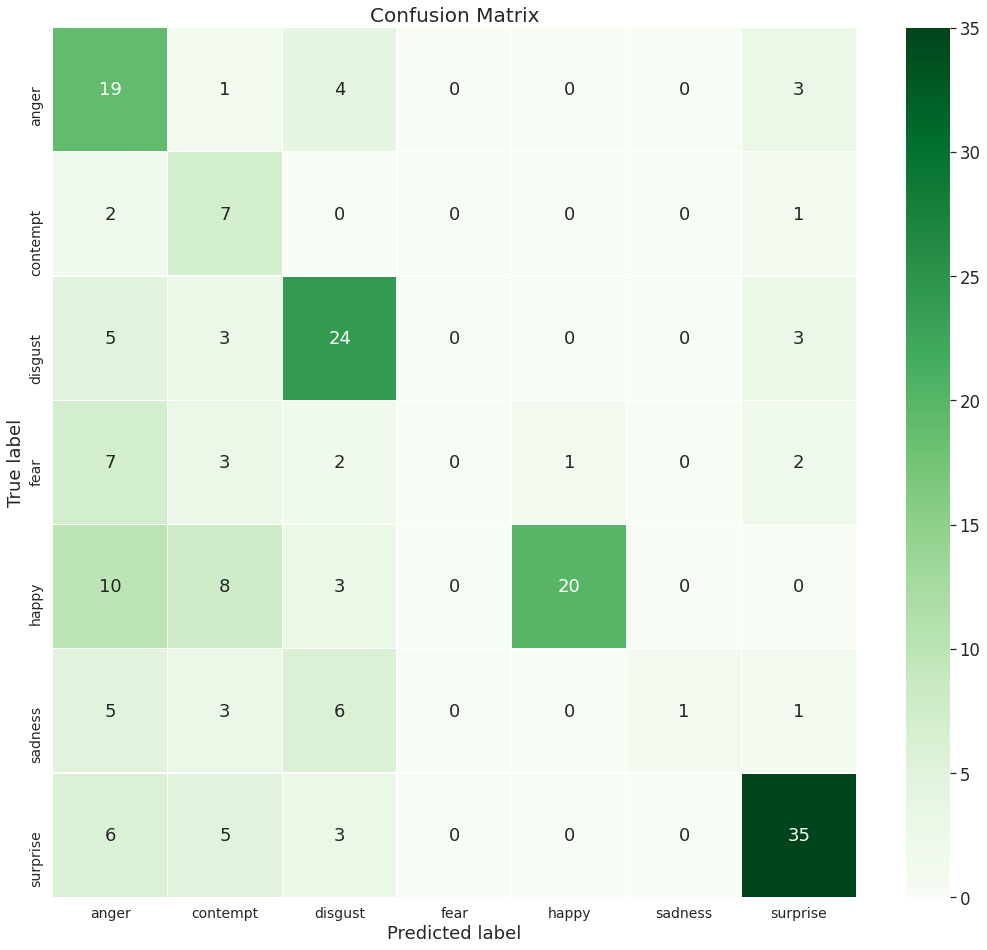

In [ ]:
y_predict = clf.predict(X_test_p)
create_confmat(y_test , y_predict , ['anger' , 'contempt' , 'disgust' , 'fear' , 'happy' , 'sadness' , 'surprise'])